In [22]:
import time, cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy.sparse.linalg import spsolve

In [6]:
def create_A(mask):
    m, n = mask.shape
    row_indices = []
    col_indices = []

    for i in range(m):
        for j in range(n):
            if mask[i, j] == 1:
                row_indices.append(i * n + j)
                col_indices.append(i * n + j)

    nnz = len(row_indices)  
    data = np.ones(nnz)
    A = csr_matrix((data, (row_indices, col_indices)), shape=(nnz, m * n))
    return A

In [3]:
def create_D(m, n):
    # Horizontal gradient
    ones_mnm = -np.append(np.ones(m * n - m), np.zeros(m))
    ones_mm = -np.append(np.ones(m - 1), [0])
    data = np.vstack((ones_mnm, np.ones(m * n)))
    dgs = np.array([0, m])
    Dx = sparse.spdiags(data, dgs, m * n, m * n)
    
    # Vertical gradient
    data = np.vstack((ones_mm, np.ones(m)))
    dgs = np.array([0, 1])
    Dy_Base = sparse.spdiags(data, dgs, m, m)
    Dy = sparse.kron(sparse.eye(n), Dy_Base)
    
    # Stack Dx and Dy to form D
    D = sparse.vstack([Dx, Dy])
    return D

In [45]:
def cg_method(B, c, x0=None, tol=1e-4, max_iterations=1000, epsilon=1e-10):
    n = len(c)
    if x0 is None:
        x0 = np.zeros(n)

    x = x0.copy()
    r = B.dot(x) - c
    p = -r.copy()

    for k in range(max_iterations):
        Ap = B.dot(p)
        denominator = np.dot(p, Ap) + epsilon  # Add epsilon to avoid division by zero
        alpha = np.dot(r, r) / denominator
        x += alpha * p
        r_new = r + alpha * Ap

        if np.linalg.norm(r_new) <= tol:
            break

        beta = np.dot(r_new, r_new) / (np.dot(r, r) + epsilon)  # Add epsilon to avoid division by zero
        p = -r_new + beta * p
        r = r_new

    return x

In [76]:
# Load your image and mask
image = cv2.imread('test_images/wallpaper.jpg', cv2.IMREAD_GRAYSCALE)
image = cv2.resize(image, (mask.shape[1], mask.shape[0]))
mask = cv2.imread('test_masks/640_640_random50.png', cv2.IMREAD_GRAYSCALE)

# Get the dimensions of the image
m, n = image.shape

# Create matrices A and D
A = create_A(mask)
D = create_D(m, n)

In [77]:
# Vectorize the image and mask
b = image.flatten()
mask_vector = mask.flatten()

# Create matrices A and D
A = create_A(mask)  # Pass the original 2D mask
D = create_D(m, n)  # Pass the dimensions m and n

# Set the regularization parameter
mu = 0.01

# Create the system matrix B and the right-hand side vector c
B = A.T.dot(A) + mu * D.T.dot(D)
c = A.T.dot(b[:A.shape[0]])  # Ensure b is compatible with A.T

# Conjugate Gradient Method
start_time = time.time()
x_cg = cg_method(B, c, tol=1e-2)
cg_time = time.time() - start_time

# Standard Solver
start_time = time.time()
x_spsolve = spsolve(B, c)
spsolve_time = time.time() - start_time

In [78]:
def calculate_psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Assuming u is the original image vector and x_cg or x_spsolve is the reconstructed image vector
original_image_vector = image.flatten()  # Original image vector
reconstructed_image_vector_cg = x_cg  # Reconstructed image vector from CG method
reconstructed_image_vector_spsolve = x_spsolve  # Reconstructed image vector from spsolve

# Calculate PSNR for both methods
psnr_cg = calculate_psnr(original_image_vector, reconstructed_image_vector_cg)
psnr_spsolve = calculate_psnr(original_image_vector, reconstructed_image_vector_spsolve)

print(f"Conjugate Gradient PSNR: {psnr_cg}, Time: {cg_time}")
print(f"Standard Solver PSNR: {psnr_spsolve}, Time: {spsolve_time}")
print(f"CG is {spsolve_time / cg_time:.2f} times faster than spsolve.")

Conjugate Gradient PSNR: 14.12475395870265, Time: 0.0046465396881103516
Standard Solver PSNR: 14.12475395870265, Time: 1.9743359088897705
CG is 424.90 times faster than spsolve.


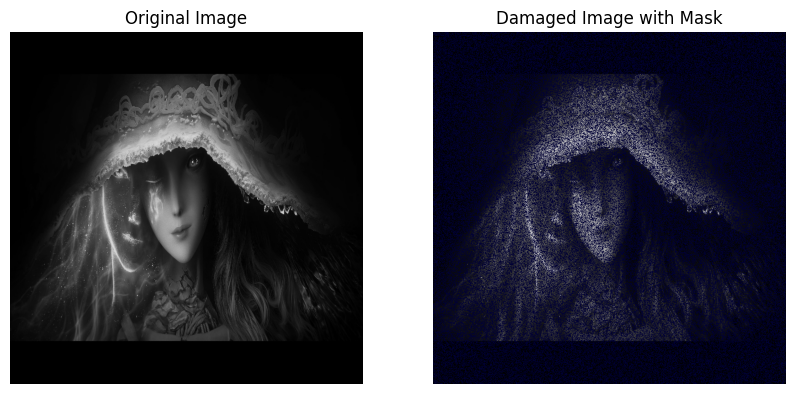

In [75]:
# Load the original image and mask
original_image = cv2.imread('test_images/wallpaper.jpg', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('test_masks/640_640_random50.png', cv2.IMREAD_GRAYSCALE)

# Resize the image and mask to match
original_image = cv2.resize(original_image, (mask.shape[1], mask.shape[0]))

# Convert the original image to BGR format
original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# Define the color for the mask (e.g., green)
mask_color = np.array([53, 1, 1])

# Apply the mask to the original image
damaged_image = original_image_bgr.copy()
damaged_image[mask == 0] = mask_color

# Display the original and damaged images in the same plot
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the damaged image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(damaged_image, cv2.COLOR_BGR2RGB))
plt.title('Damaged Image with Mask')
plt.axis('off')

plt.show()

# Save the damaged image
plt.imsave('damaged_image_wallpaper.png', damaged_image)

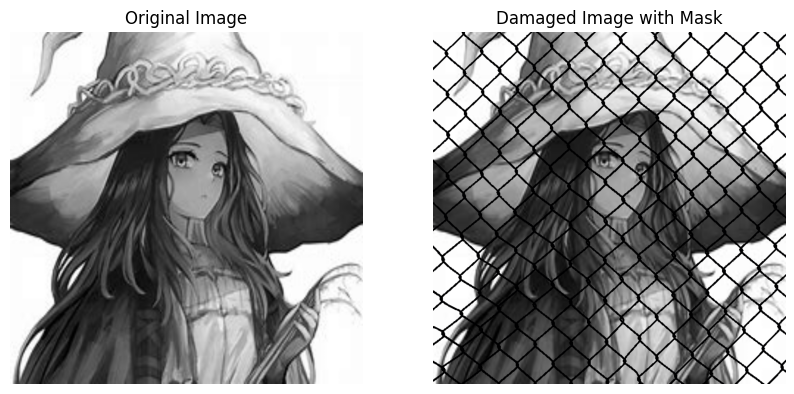

In [11]:
# Load the original image and mask
original_image = cv2.imread('test_images/Ranni_the_Witch.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('test_masks/640_640_mesh.png', cv2.IMREAD_GRAYSCALE)

# Resize the image and mask to match
original_image = cv2.resize(original_image, (mask.shape[1], mask.shape[0]))

# Convert the original image to BGR format
original_image_bgr = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)

# Define the color for the mask (e.g., green)
mask_color = np.array([1, 0, 0])

# Apply the mask to the original image
damaged_image = original_image_bgr.copy()
damaged_image[mask == 0] = mask_color

# Display the original and damaged images in the same plot
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the damaged image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(damaged_image, cv2.COLOR_BGR2RGB))
plt.title('Damaged Image with Mask')
plt.axis('off')

plt.show()

# Save the damaged image
plt.imsave('damaged_image_RanniS.png', damaged_image)